In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate_PT = ["SimPhotonsVIS", "SimPhotonsVUV", "eventID", 
                           "TrackID"]
branches_to_activate_total = ["stepX", "dE", "PDGcode", "eventID", "E"]

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

In [4]:
################################################################################
# MAIN LOOP
################################################################################

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
skip = os.path.join(ROOT, ".DS_Store/")
count=0
list_dE, list_E, list_integrate = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

for folder in os.listdir(ROOT): 
    PATH = os.path.join(ROOT, folder)
    PATH += "/"
    
    if (PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(PATH):
        file = os.path.join(PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            # first tree: per particle
            tree = rootfile["opanatree/OpAnaPerTrackTree"]
            branches = tree.arrays(branches_to_activate_PT, library="np") 
            
            list_mu, list_e = etl.GTsignalsExtraction(eventID = branches['eventID'], 
                                                      signalsVIS = branches['SimPhotonsVIS'], 
                                                      signalsVUV = branches['SimPhotonsVUV'], 
                                                      trackID = branches['TrackID'], 
                                                      id=1, count=count)
            
            
            # second tree: with total signal
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate_total, library="np") 
            dE, E = [], []
            
            for entry in range(len(branches["eventID"])): # entries loop
                event = branches["eventID"][entry]

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry], 
                #                                        branches["PDGcode"][entry],
                #                                        branches["dE"][entry])
                
                dE_e, E_e, _ = etl.getElectron2EnergiesAndX0(branches["stepX"][entry], 
                                                               branches["PDGcode"][entry],
                                                               branches["dE"][entry],
                                                               branches["E"][entry])
                dE.append(dE_e) # Mev
                E.append(E_e*1e+03) # GeV to Mev
                
            cal = calibration(list_e, t, multiple=True)
            list_integrate.append(cal._integrateSignal())
            list_dE.append(dE)
            list_E.append(E)
                
            
        # finish of file
        print(f'Time spent with tree {count}: {time()-mi} ')
        # print(np.shape(list_dE), np.shape(list_integrate))
        count+=1
        
print(f'Total time processing data: {time()-m0} ')

Time spent with tree 0: 0.5711441040039062 
Time spent with tree 1: 0.5915498733520508 
Time spent with tree 2: 0.6157729625701904 
Time spent with tree 3: 0.5908167362213135 
Time spent with tree 4: 0.6421599388122559 
Time spent with tree 5: 0.5971851348876953 
Time spent with tree 6: 0.5996191501617432 
Time spent with tree 7: 0.6362168788909912 
Time spent with tree 8: 0.6082258224487305 
Time spent with tree 9: 0.6258277893066406 
Time spent with tree 10: 0.5995190143585205 
Time spent with tree 11: 0.6482586860656738 
Time spent with tree 12: 0.5870766639709473 
Time spent with tree 13: 0.5914199352264404 
Time spent with tree 14: 0.648902177810669 
Time spent with tree 15: 0.5903520584106445 
Time spent with tree 16: 0.6027209758758545 
Time spent with tree 17: 0.6425979137420654 
Time spent with tree 18: 0.6080770492553711 
Time spent with tree 19: 0.6312451362609863 
Time spent with tree 20: 0.6043927669525146 
Time spent with tree 21: 0.6435229778289795 
Time spent with tree 

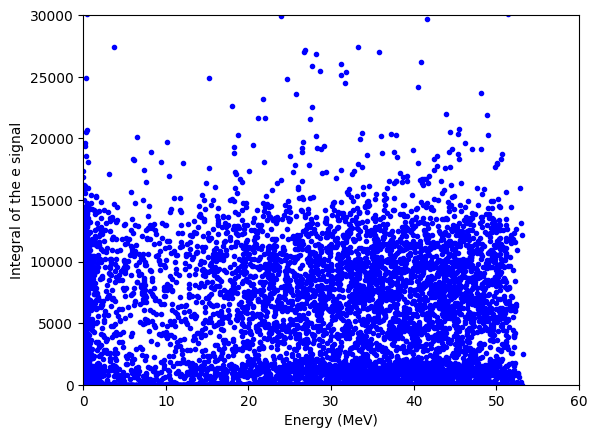

In [64]:
x = np.array(list_dE).reshape(-1)
y = np.array(list_integrate).reshape(-1)

idx = np.where(x>0)
x = x[idx]
y = y[idx]

order = np.argsort(x)
x = x[order]
y = y[order]

plt.figure()
plt.plot(x, y, '.b')
plt.xlabel('Energy (MeV)')
plt.ylabel('Integral of the e signal')
plt.xlim(0,60)
plt.ylim(0,30000)
plt.show()

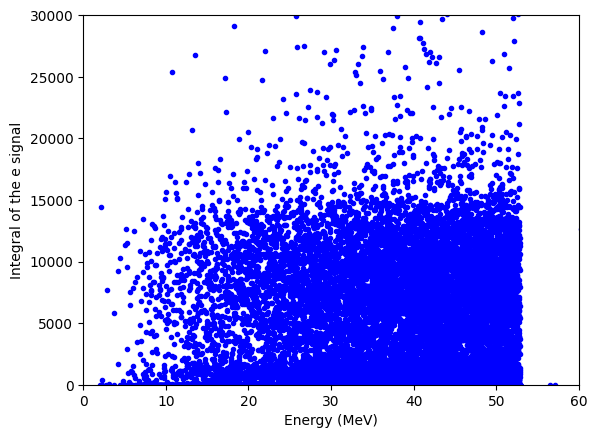

In [62]:
x = np.array(list_E).reshape(-1)
y = np.array(list_integrate).reshape(-1)

idx = np.where(x>0)
x = x[idx]
y = y[idx]

order = np.argsort(x)
x = x[order]
y = y[order]

plt.figure()
plt.plot(x, y, '.b')
plt.xlabel('Energy (MeV)')
plt.ylabel('Integral of the e signal')
plt.xlim(0,60)
plt.ylim(0,30000)
plt.show()